Data generation for 1D burgers equation using finite differences discretization in space, and an ODE solver for time.

In [9]:
using Pkg
Pkg.activate(".")
using OrdinaryDiffEq
using ComponentArrays
using Plots
using JLD2

  Activating new project at `~/Code/surrogate_flow`


In [10]:
struct burgers_equation
    Δx::Float64 # grid spacing
    ν::Float64 # viscosity
    du_dx::Vector{Float64} # temporary storage for du/dx
    d2u_dx2::Vector{Float64} # temporary storage for d2u/dx2
end

function dx!(du,u,Δx) #upwind du_dx for u*du/dx term
    n=length(u)
    for i=2:n
        du[i]=(u[i]-u[i-1])/Δx
    end
    du[1]=(u[1]-u[end])/Δx
end

function dx2!(du,u,Δx) #central second difference for ν d2u/dx2 term
    n=length(u)
    for i=2:n-1
        du[i]=(u[i+1]-2*u[i]+u[i-1])/(Δx^2)
    end
    du[1]=(u[end]-2*u[1]+u[2])/(Δx^2)
    du[end]=(u[end-1]-2*u[end]+u[1])/(Δx^2)
end

"""
# Define the function that computes the time derivative of the state
 du/dt = -u * du/dx + ν * d2u/dx2
"""
function (f::burgers_equation)(du_dt, u, p, t)
    Δx=f.Δx
    ν=f.ν
    du_dx=f.du_dx
    d2u_dx2=f.d2u_dx2
    dx!(du_dx,u,Δx)
    dx2!(d2u_dx2,u,Δx)
    @. du_dt = -u*du_dx + ν*d2u_dx2 
    # The diffusion term is switched off because the first order upwind scheme is numerically diffusive
end

function burgers_initial_condition(x,k,u_mean=1.0,u_amplitude=0.5)
    return u_mean .+ u_amplitude.*cos.(k*x)
end


burgers_initial_condition (generic function with 3 methods)

In [11]:
# setting up the problem

# parameters
nx=100     # number of spatial points
L=10.0     # length of the domain
Δx=L/nx    # spatial step
ν=0.1    # viscosity
k=2*pi/L   # wave number for initial condition
u_mean=1 # mean velocity
u_amplitude=0.5 # amplitude of the initial condition
p=()       # parameters (not used in this case)

# spatial grid
x=Δx*(1:nx) # spatial grid points

# initial condition
u0 = burgers_initial_condition(x,k,u_mean,u_amplitude)

# initialize model struct
f=burgers_equation(Δx, ν, similar(u0), similar(u0))

# time span
t_end=5

5

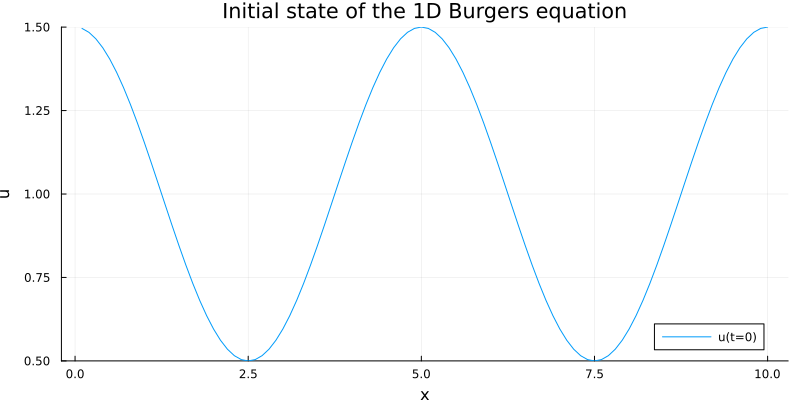

In [4]:
# plot the initial state
p1=plot(x, u0, label="u(t=0)", xlabel="x", ylabel="u")
plot(p1, size=(800,400), title="Initial state of the 1D Burgers equation",ylim=(u_mean-u_amplitude, u_mean+u_amplitude))

In [12]:
prob = ODEProblem(f, u0, (0.0, t_end))
@time sol = solve(prob, Tsit5()) # store output, no timing

nothing

  0.453776 seconds (168.50 k allocations: 9.388 MiB, 99.94% compilation time: 100% of which was recompilation)


[ Info: Saved animation to /home/mlenes/Code/surrogate_flow/burgers_residuals.gif


  5.694049 seconds (3.09 M allocations: 155.863 MiB, 0.46% gc time, 19.06% compilation time)


Plots.AnimatedGif("/home/mlenes/Code/surrogate_flow/burgers_residuals.gif")
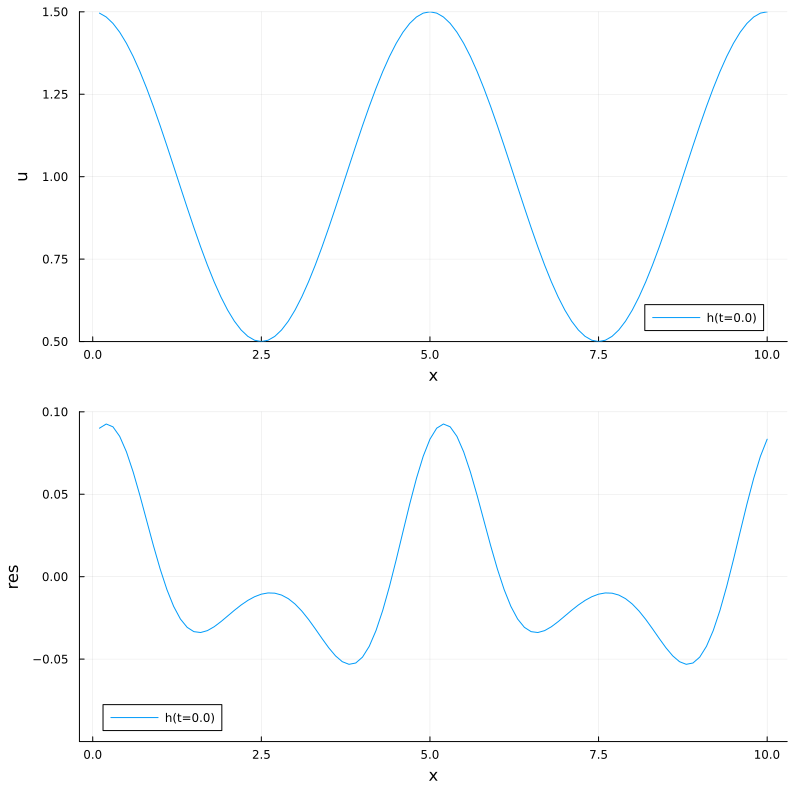

In [6]:
residuals = []

for t_idx in 1:length(sol.t)-1
    u1 = sol.u[t_idx]

    du_dx = similar(u1)
    du2_dx2 = similar(u1)

    dx!(du_dx, u1, Δx)
    dx2!(du2_dx2, u1, Δx)

    rhs = -du_dx.*u1 + ν*du2_dx2
    du_dt = (sol.u[t_idx+1] - sol.u[t_idx])/(sol.t[t_idx+1]-sol.t[t_idx])
    res = rhs - du_dt
    push!(residuals, res)
end

@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)-1
        plt = plot(layout = (2,1), size=(800,800))
        plot!(plt[1], x, sol[i], label="h(t=$(round(sol.t[i],digits=2)))", xlabel="x", ylabel="u", ylim=(u_mean-u_amplitude, u_mean+u_amplitude))
        plot!(plt[2], x, residuals[i], label="h(t=$(round(sol.t[i],digits=2)))", xlabel="x", ylabel="res", ylim=(-0.1,0.1))
    end
    gif(anim, "burgers_residuals.gif", fps=8)
end


  3.944413 seconds (726.54 k allocations: 38.941 MiB, 0.50% gc time)


[ Info: Saved animation to /home/mlenes/Code/surrogate_flow/burgers1d_periodic.gif


Plots.AnimatedGif("/home/mlenes/Code/surrogate_flow/burgers1d_periodic.gif")
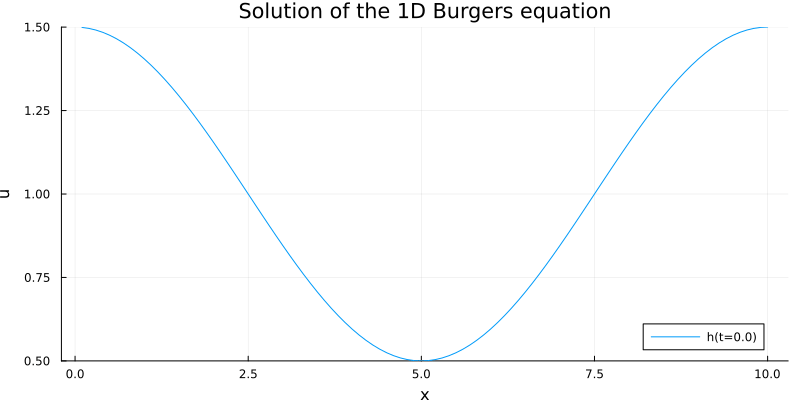

In [13]:
# create a movie of the solution
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)
        p1 = plot(x, sol[i], label="h(t=$(round(sol.t[i],digits=2)))", xlabel="x", ylabel="u", ylim=(u_mean-u_amplitude, u_mean+u_amplitude))
        plot(p1, size=(800,400), title="Solution of the 1D Burgers equation")
    end
    gif(anim, "burgers1d_periodic.gif", fps=15)
end

In [14]:
# save the solution to a JLD2 file
cfl_out=1 # CFL number for output
dt_out=cfl_out*f.Δx/u_mean # time step for output, based on CFL condition
times=collect(0.0:dt_out:t_end) # output times
solution=[]
for t in times
    push!(solution, sol(t))
end
# save the solution to a JLD2 file
save("burgers1d_periodic.jld2", 
    "solution", solution,
    "times", times,
    "params", (ν=ν, Δx=Δx, u_mean=u_mean, u_amplitude=u_amplitude, k=k),
    "grid", x,
    "cfl_out", cfl_out,
    "dt_out", dt_out,
    "description", "Solution of the 1D Burgers equation with periodic boundary conditions, using a cosine as initial condition.")


Surrogate model training

In [101]:
using Flux
using BSON
using Plots, Measures
using JLD2
using ProgressMeter

const use_gpu = true
if use_gpu
    using cuDNN, CUDA
    CUDA.allowscalar(false)
    if CUDA.functional()
        println("CUDA is functional, using GPU")
    else
        error("CUDA is not functional, using CPU")
    end
end

CUDA is functional, using GPU


In [102]:
# Settings

# Training
n_epochs = 1000
batch_size = 40
learning_rate = 0.005

# data
n_train = 40
n_val = 10

# model
n_in = 1
n_out = 1
n_hidden = 8
n_filter = 3

3

In [103]:
data=load("burgers1d_periodic.jld2")

# sizes
n_times = length(data["solution"])
n_steps=n_times-1
n_points = length(data["solution"][1])

# Create inputs X and outputs Y
X = zeros(Float32, n_points, 1, n_times-1)
Y = zeros(Float32, n_points, 1, n_times-1)
for t in 1:n_times-1
    X[:,:,t] .= data["solution"][t]
    Y[:,:,t] .= data["solution"][t+1]
end

@show size(X)
@show size(Y)

# some metadata for plotting
output_times = data["times"][2:end]
output_x = data["grid"]
x0 = X[:,:,1] # initial conditions for rollout

nothing

size(X) = (100, 1, 50)
size(Y) = (100, 1, 50)


In [104]:
# Split the data into training and validation sets

# check if we have enough data to make a training and validation split
n_samples = size(X, 3)
if n_train + n_val > n_samples
    error("n_train + n_val must be less than or equal to the number of samples: $n_samples")
end

# Split the data into training and validation sets
X_train_cpu = X[:,:,1:n_train]
Y_train_cpu = Y[:,:,1:n_train]
X_val_cpu = X[:,:,n_train+1:n_train+n_val]
Y_val_cpu = Y[:,:,n_train+1:n_train+n_val]
@show size(X_train_cpu), size(Y_train_cpu)
@show size(X_val_cpu), size(Y_val_cpu)
nothing

(size(X_train_cpu), size(Y_train_cpu)) = ((100, 1, 40), (100, 1, 40))
(size(X_val_cpu), size(Y_val_cpu)) = ((100, 1, 10), (100, 1, 10))


In [105]:
# move data to gpu or keep on cpu
if use_gpu
    X_train = gpu(X_train_cpu)
    Y_train = gpu(Y_train_cpu)
    X_val = gpu(X_val_cpu)
    Y_val = gpu(Y_val_cpu)
else
    X_train = X_train_cpu
    Y_train = Y_train_cpu
    X_val = X_val_cpu
    Y_val = Y_val_cpu
end

# create the data loaders
train_loader = Flux.DataLoader((X_train, Y_train), batchsize=min(batch_size,n_train), shuffle=true)

val_loader = Flux.DataLoader((X_val, Y_val), batchsize=min(batch_size,n_val), shuffle=false)
@show train_loader
@show val_loader
nothing

train_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, shuffle=true, batchsize=40)
val_loader = DataLoader(::Tuple{Array{Float32, 3}, Array{Float32, 3}}, batchsize=10)


In [106]:
# Create the model
n_pad=n_filter ÷ 2 # padding for the convolutional layer
PadCircular(x) = pad_circular(x, (n_pad,n_pad,0,0,0,0))

model_residual = Chain(
    PadCircular,
    Conv((n_filter,), n_in=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    PadCircular,
    Conv((n_filter,), n_hidden=>n_out)
)

# Define the model with residual block
struct ResidualBlock
    f::Chain
end

# Define how the ResidualBlock works
(m::ResidualBlock)(x) = x + m.f(x)

# Allow Flux to recognize ResidualBlock as a layer
Flux.@layer ResidualBlock

# create the model with residual blocks
model_cpu = ResidualBlock(model_residual)

# Show the model strucure and number of parameters
@show model_cpu

# Move model to gpu or keep on cpu
if use_gpu
    model = gpu(model_cpu)
else
    model = model_cpu
end

model_cpu = ResidualBlock(Chain(PadCircular, Conv((3,), 1 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 1)))


ResidualBlock(
  Chain(
    Main.PadCircular,
    Conv((3,), 1 => 8, swish),          # 32 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 8, swish),          # 200 parameters
    Main.PadCircular,
    Conv((3,), 8 => 1),                 # 25 parameters
  ),
)                   # Total: 8 arrays, 457 parameters, 2.387 KiB.

In [107]:
# Train the model

# Initialize the ADAM optimizer with default settings
optimizer = Flux.setup(Adam(learning_rate),model)

# train loop
train_loss = Float32[]
val_loss = Float32[]
@showprogress for epoch in 1:n_epochs
    # Train the model on the training data
    # Loop over minibathches in the training data
    for (x_batch, y_batch) in train_loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x_batch) # apply the model to the input batch
            Flux.mse(y_hat, y_batch) # compute the loss
        end
        Flux.update!(optimizer, model, grads[1])
    end
    # evaluate over all training data and validation data
    # NOTE: we careless with compute, rerunning model each time below
    Y_train_hat = model(X_train)
    train_loss_epoch = Flux.mse(Y_train_hat, Y_train)
    push!(train_loss, train_loss_epoch)
    Y_val_hat = model(X_val)
    val_loss_epoch = Flux.mse(Y_val_hat, Y_val)
    push!(val_loss, val_loss_epoch)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


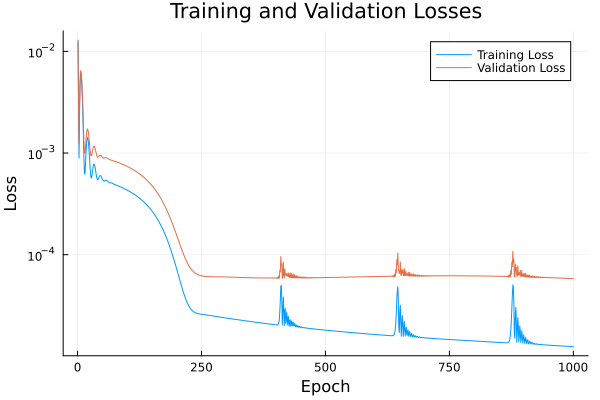

In [108]:
# Plot losses for training and validation
plot(train_loss, label="Training Loss", xlabel="Epoch", ylabel="Loss", title="Training and Validation Losses",yscale=:log10)
plot!(val_loss, label="Validation Loss", xlabel="Epoch",yscale=:log10)

In [109]:
# unroll the model to get the output for the initial condition
function unroll(model, x0, n_steps)
    x = reshape(x0, size(x0, 1), size(x0, 2), 1) # ensure x0 is 3
    outputs = zeros(Float32, size(x0, 1), size(x0, 2), n_steps+1)
    outputs[:,:,1] .= x0 # store the initial condition
    # unroll the model for nstep
    for t in 1:n_steps
        x = model(x)
        outputs[:,:,t+1] .= x
    end
    return outputs
end

# unroll the model to get the output for the initial condition
Y_unroll = unroll(model_cpu, x0, n_steps)

nothing

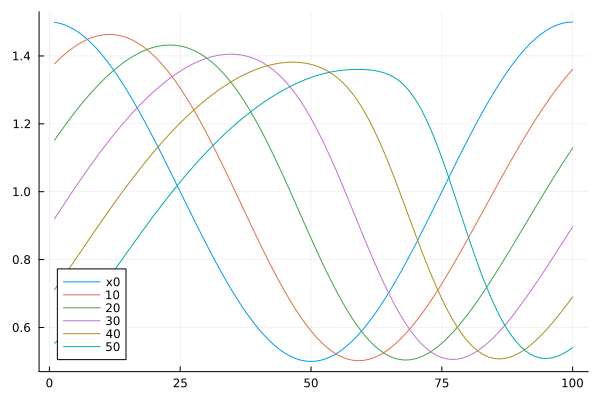

In [110]:
# plot some snapshots of the unrolled model output
plot(Y_unroll[:, 1, 1], label="x0")
plot!(Y_unroll[:,1,11], label="10")
plot!(Y_unroll[:,1,21], label="20")
plot!(Y_unroll[:,1,31], label="30")
plot!(Y_unroll[:,1,41], label="40")
plot!(Y_unroll[:,1,51], label="50")

  1.675078 seconds (559.04 k allocations: 26.708 MiB, 0.47% gc time)


[ Info: Saved animation to /home/mlenes/Code/surrogate_flow/burgers1d_periodic_ml_unroll.gif


Plots.AnimatedGif("/home/mlenes/Code/surrogate_flow/burgers1d_periodic_ml_unroll.gif")
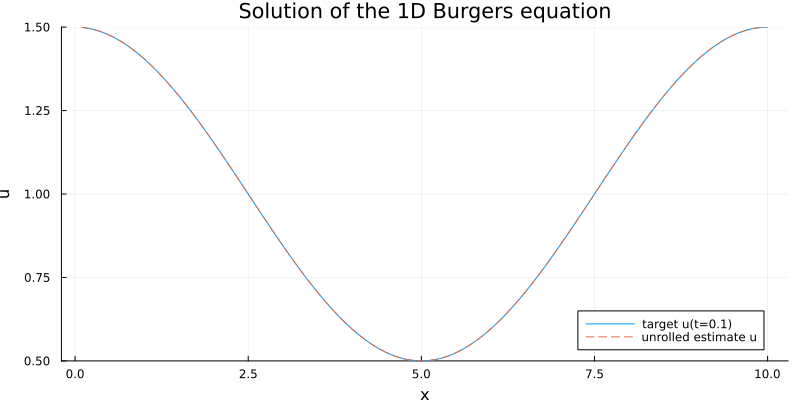

In [111]:
# Make movie of the unrolled output
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(output_times)
        p1 = plot(output_x, X[:,1,i], label="target u(t=$(round(output_times[i],digits=2)))", xlabel="x", ylabel="u", ylim=(u_mean-u_amplitude, u_mean+u_amplitude))
        plot!(output_x, Y_unroll[:,1,i], label="unrolled estimate u", linestyle=:dash)
        plot(p1, size=(800,400), title="Solution of the 1D Burgers equation")
    end
    gif(anim, "burgers1d_periodic_ml_unroll.gif", fps=15)
end